# Toy Latent Variable Model
Consider a simple latent variable model where we have observations $y_1, \dots, y_n \in \mathbb{R}^d$ drawn from
    \begin{align*}
        z|\theta &\sim \mathcal{N}(\cdot;\theta \textsf{1}_d, \textsf{Id}_d)\\
        y|z &\sim \mathcal{N}(\cdot;z, \textsf{Id}_d)
    \end{align*}
    where $\theta\in\mathbb{R}$ and $\textsf{1}_d, \textsf{Id}_d$ denote the $d$-dimensional vector of ones and the $d\times d$ identity matrix respectively.

In [103]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [149]:
D = 100  # Dimensionality of latent variables.
thdata = 1  # Parameter value used to generate the data.

# Generate the data:
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

In [150]:
# get MLE
theta_mle = np.mean(y)
theta_mle

1.0871793318123344

## Adaptive step size

In [217]:
#Set approximation parameters:
Niter = 500  # Number of steps.
N = 500  # Number of particles.

th0 = np.array([0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [218]:
def next_gamma_md(current_gamma, alpha, logW):
    N = logW.shape[0]
    def f(e):
        ess = rs.essl(e * logW) if e > 0.0 else N  # avoid 0 x inf issue when e==0
        return ess - alpha * N
    if f(0)*f(1) < 0.:
        return optimize.brentq(f, 0, 1.0)
    else:
        return 1.0

In [219]:
gamma = np.array([0])
Cn = np.array([1])
theta = np.array([])
n = -1
epsilon = 1e-5

In [220]:
while((gamma[n+1]<1) & (n < Niter)):
    n = n+1
    print(n)
    if (n == 0):
        theta = np.append(theta, theta_mle)
        x = np.random.normal(size = (N, D))
    else:
        Cn = np.append(Cn, np.prod(1-gamma[1:]))
#         theta = np.append(theta, theta[n-1] + gamma[n]*(np.sum(np.sum(x, axis = 1)*W)-D*theta[n-1]))
        theta = np.append(theta, theta_mle)
        # resample
        ancestors = rs.resampling('stratified', W)
        x = x[ancestors, :]
        # MCMC move
        prop = md_lvm.rwm_proposal(x, W)
        x = md_lvm.rwm_accept_toy_lvm_varying_gamma(x, prop, theta[:n], gamma[1:(n+1)], y)
    # reweight
    logW = md_lvm.ll_toy_lvm(theta[n], x, y) + 0.5*np.prod(1-gamma[1:n])*np.sum(x**2, axis = 1)
    for k in range(n-1):
        logW = logW - gamma[k+1]*np.prod(1-gamma[(k+2):n])*md_lvm.ll_toy_lvm(theta[k], x, y)
    new_l = next_gamma_md(gamma[n], 0.5, logW)
    gamma = np.append(gamma, new_l)
    logW = gamma[n+1]*logW
    W = rs.exp_and_normalise(logW)

0
1
2
3
4
5
6
7
8
9


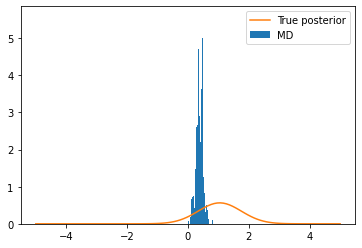

In [221]:
plt.hist(x[:, 0], density = True, bins = 50, weights = W, label='MD');
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), scale = np.sqrt(0.5), loc = 0.5*(np.mean(y)+1)), label = 'True posterior')
plt.legend()
# plt.savefig('toy_posterior_optimal_gamma.pdf', bbox_inches="tight")

In [223]:
gamma

array([0.        , 0.03465484, 0.03950442, 0.05107632, 0.06793933,
       0.10157533, 0.14685512, 0.21014793, 0.36841715, 0.75443457,
       1.        ])

In [196]:
class ToyBridge(ssp.TemperingBridge):
    def logtarget(self, x):
        log_p = -0.5*np.sum((x - theta_mle)**2, axis = 1)
        log_p = log_p - 0.5*np.sum((x-y.T)**2, axis = 1)
        return log_p

In [197]:
base_dist = dists.MvNormal(scale=1., cov=np.eye(D))
toy_bridge = ToyBridge(base_dist=base_dist)

In [212]:
fk_tpr = ssp.AdaptiveTempering(model=toy_bridge, wastefree = False)
alg = particles.SMC(fk=fk_tpr, N=500, ESSrmin=1., verbose=True)
alg.run()

t=0, ESS=250.00, tempering exponent=0.0345
t=1, Metropolis acc. rate (over 9 steps): 0.268, ESS=250.00, tempering exponent=0.0744
t=2, Metropolis acc. rate (over 9 steps): 0.305, ESS=250.00, tempering exponent=0.12
t=3, Metropolis acc. rate (over 9 steps): 0.355, ESS=250.00, tempering exponent=0.176
t=4, Metropolis acc. rate (over 9 steps): 0.397, ESS=250.00, tempering exponent=0.248
t=5, Metropolis acc. rate (over 9 steps): 0.424, ESS=250.00, tempering exponent=0.335
t=6, Metropolis acc. rate (over 9 steps): 0.473, ESS=250.00, tempering exponent=0.447
t=7, Metropolis acc. rate (over 9 steps): 0.505, ESS=250.00, tempering exponent=0.601
t=8, Metropolis acc. rate (over 9 steps): 0.524, ESS=250.00, tempering exponent=0.801
t=9, Metropolis acc. rate (over 9 steps): 0.534, ESS=300.57, tempering exponent=1


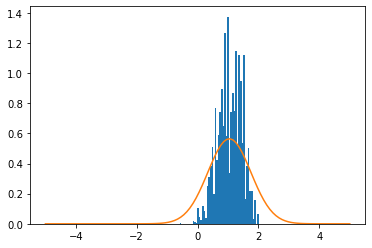

In [213]:
plt.hist(alg.X.theta[:, 0], density = True, weights = alg.W, bins = 50)
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), scale = np.sqrt(0.5), loc = 0.5*(np.mean(y)+1)))

In [214]:
l = alg.X.shared['exponents']
gamma = np.array([0])

In [215]:
for n in range(1,len(l)):
    gamma = np.append(gamma, (l[n]-l[n-1])/(1-l[n-1]))

In [216]:
gamma

array([0.        , 0.03454595, 0.04131307, 0.049529  , 0.06327398,
       0.0878059 , 0.1148841 , 0.16922791, 0.27877389, 0.50192222,
       1.        ])